In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import os 
import cmasher as cmr
import sys
sys.path.append('Lib/')
from Zams_KDE_files import CMDFormatter
from astropy.io import ascii
from matplotlib import rcParams
from scipy import stats
directory = os.getenv("DATADIR")

plt.style.use(directory+'bl.mplstyle')
#rcParams["mathtext.fontset"] = 'cm'
dir = directory + '4_MagellanicClouds/Extinction/'

#######################
# Set Plot Parameters #
#######################
labelsize = 12
ticksize = 10
textsize = 11
legendsize = 11

background_c = '#F6FBFE' 
background_a = 1 

smc = CMDFormatter('smc')
lmc = CMDFormatter('lmc')

mesa_lmc = lmc.Generate_MS_Table()
mesa_smc = smc.Generate_MS_Table()
mesa_df = {r"Z$_{LMC}$": mesa_lmc, 'Z$_{SMC}$': mesa_smc}

dc = ['#A5d8ff','#8FE388','#6290c3','']

color_space = ['uvm2_v','uvw1_b','u_v']

alphas = [1,1,1,0.7]
ns = [200,50,50,30]
zorders = [7,6,5,4]

c1 = '#fe439b' 
c4 = 'k'#'#5E917A' #'#72788D'
c3 = '#A4C2F4' 
c5 = '#7A89C2'
c2 = '#E3D7FF'

colors = ['#fe439b',  '#E3D7FF','#72788D', '#7A89C2']

ranks = ['VB-E', 'VB-G', 'B-E', 'B-G']
rank_colors = [c1,c2,c3,c4]


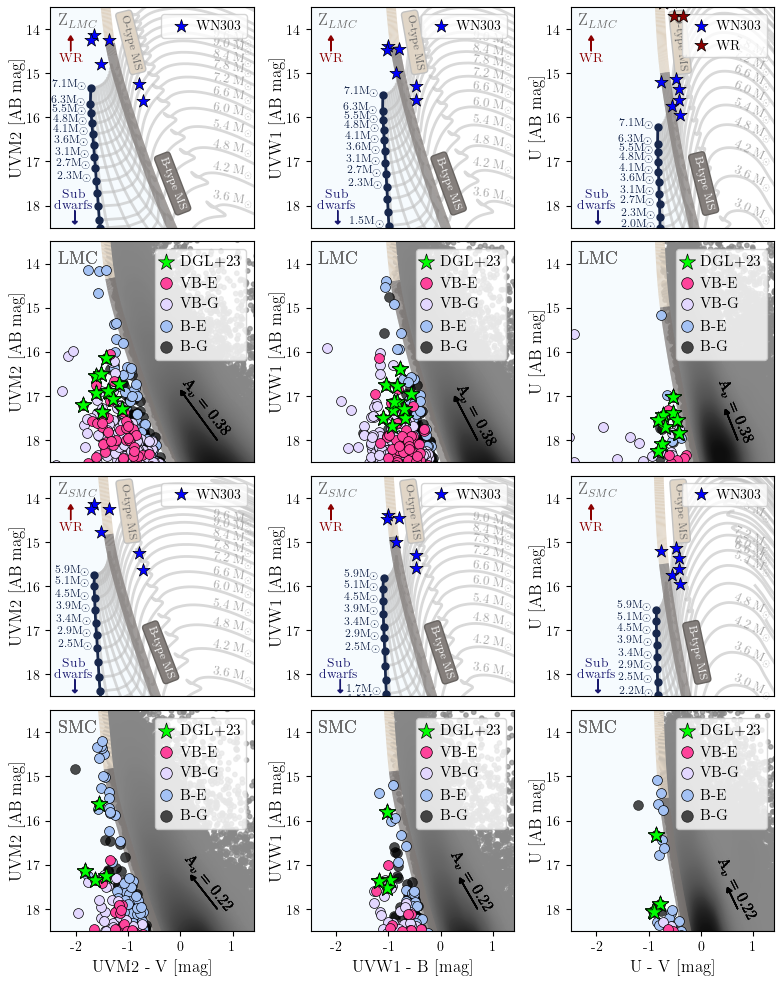

In [120]:
f, axes = plt.subplots(4,3,figsize=(8.,10.))

counter_top, counter_bottom = 0, 0
for galaxy, galaxy_label, axs in zip([lmc,lmc,smc,smc],[r"Z$_{LMC}$","LMC",r"Z$_{SMC}$","SMC"],[axes[0,:],axes[1,:],axes[2,:],axes[3,:]]):
    
    for ax,colorspace,i in zip(axs.flatten(),color_space,range(len(color_space))):
        uv, opt = colorspace.split('_')

        # Plot ZAMS
        lc,zams_x,zams_y = galaxy.zams_threshold_plot(ax, uv, opt)
        lc.set_linewidth(7)
        ax.fill_betweenx(zams_y,np.repeat(-3,len(zams_y)),zams_x,alpha=background_a ,color=background_c,zorder=0)

        # Formatting
        xlabels  = ['UVM2 - V [mag]','UVW1 - B [mag]','U - V [mag]']
        ylabels  = ['UVM2 [AB mag]','UVW1 [AB mag]','U [AB mag]']
        ax.set_xlabel(xlabels[i],fontsize=labelsize)
        ax.set_ylabel(ylabels[i],fontsize=labelsize, labelpad=1.5)
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.set_ylim(18.5,13.5)
        ax.set_xlim(-2.49,1.4)
        ax.set_xticks([-2,-1,0,1])
        ax.set_xticklabels([-2,-1,0,1])

        # Bottom two rows
        if galaxy_label != r"Z$_{LMC}$" and galaxy_label != r"Z$_{SMC}$":

            # Plot kdes
            k_df = galaxy.kdes[colorspace]
            x,y,z = k_df[f'{colorspace}_x'],k_df[f'{colorspace}_y'],k_df[f'{colorspace}_z']
            a = 0.7
            if galaxy_label == "LMC":
                ax.scatter(x - 0.05,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=a,clip_on=True)
            else:
                ax.scatter(x,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=a,clip_on=True)


            # Plot Stars by rank 
            for rank,rank_color,alpha,z in zip(ranks,rank_colors,alphas,zorders):
                uv, opt = colorspace.split('_')
                df = galaxy.candidates
                # Plot confirmed candidates 
                obs_stars = [f'Star_{i}' for i in range(1,17)]
                confirmed = df[df['discovery_name'].isin(obs_stars)]
                x = confirmed[f'{uv}'] - confirmed[f'{opt}']
                y = confirmed[f'{uv}']
                a = 0.7
                ax.scatter(x,y,s=150,edgecolor='k',facecolor='lime',linewidth=0.5,marker="*",alpha=1,zorder=100,label='DGL+23',clip_on=True)

                edge_color='k'
                uv, opt = colorspace.split('_')
                df = galaxy.candidates
                rf = df[(df[f'{uv} - {opt}'] == 'blue') & (df['cut'] == rank)]
                x = rf[f'{uv}'] - rf[f'{opt}']
                y = rf[f'{uv}']
                ax.scatter(x,y,s=50,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,marker="o",alpha=alpha,zorder=z,clip_on=True)
                # For legend
                ax.scatter(0,0,s=70,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,zorder=10,label=rank,marker="o",alpha=alpha,clip_on=True)


                # Av Arrow 
                offsets_r = [6, 4, 4, 5, 5, 5]
                offsets_x = [-15, -10, -12, -17, -16, -14]
                offsets_y = [-13, -18, -11, -12, -11, -13]
                galaxy.plot_arrow(ax,x=0.7,y=18,
                                blue_band=uv,red_band=opt,
                                offset_x = offsets_x[counter_bottom], offset_y = offsets_y[counter_bottom], offset_r = offsets_r[counter_bottom], 
                                fontsize=textsize)
                ax.text(-2.35,14,galaxy_label,fontsize = legendsize+2,weight='bold',color='dimgray')
            
            # Legend
            handles, labels = axes[1,0].get_legend_handles_labels()
            # Only plot Drout+23 once
            handles = [[handles[0]] + [handles[1]] + [handles[3]] + [handles[5]] + [handles[7]]]
            labels = [[labels[0]] + [labels[1]] + [labels[3]] + [labels[5] ]+ [labels[7]]]
            # Combine handles
            ax.legend(handles[0],labels[0],fontsize=legendsize,loc='upper right',handlelength=0.6,handletextpad=0.6)#,handletextpad=-0.2)
            counter_bottom += 1
        
        # Top and middle row
        else:
            # Evolutionary Models - MS 
            vals = [float(f[:3]  + '.' + f[3]) for f in galaxy.mist_fnames]
            rotation = [-10,-8,-25,-10,-8,-25]
            text_offset = [0,0.0,0.15,0,0.0,0.15]
            min_text = [3.1,3.1,0,3.1,3.1,0]
            max_text = [9.7,9.3,8.3,9.7,9.3,8.3]

            for mdf,val in zip(mesa_df[galaxy_label],vals):
                m_x = mdf[uv.upper()] - mdf[opt.upper()]
                m_y = mdf[uv.upper()]
                ax.plot(m_x,m_y,color='silver',linewidth=2,alpha=0.6,zorder=0)
                # What is y when uv - opt = 1
                diff = np.abs(m_x - 1)
                mlabel_y = m_y[diff.argmin()]
                if val < max_text[counter_top] and val > min_text[counter_top]:
                    ax.text(.6,mlabel_y+text_offset[counter_top],f'{val} M'+r'$_\odot$',fontsize=textsize-2,color='darkgrey',rotation=rotation[counter_top]) 
                

            # Galaxy label o
            ax.text(-2.35,13.9,galaxy_label,fontsize = legendsize+1,weight='bold',color='dimgray') 
            

            # Zams Box
            Ox = [-0.95,-0.5,-0.4, -1.,-0.55,-0.4]
            Or = [-76,-80,-84,      -82,-82,-86]
            Bx = [-0.15,0.15,0.05, -0.38,0.01,-0.08]
            Br = [-69,-70,-76,     -69,-72,-78]

            galaxy.ostar_box(ax,x=Ox[counter_top] ,rotation=Or[counter_top],fontsize=textsize-3)
            galaxy.bstar_box(ax,x=Bx[counter_top],rotation=Br[counter_top],fontsize=textsize-3)

            # Evolutionary Models - Stripped stars
            evol = galaxy.composites[galaxy.composites.frac_MS==0.0]
            M = evol.M_strip.unique()

            # LMC stripped_evol_labels = [0.37, 0.42, 0.47, 0.54, 0.62, 0.7 , 0.8 , 0.92, 1.05, 1.2 , 1.38, 1.54, 1.77, 2.04, 2.34, 2.69, 3.1 , 3.58, 4.13, 4.75, 5.47, 6.28, 7.14]
            # SMC stripped_evol_labels = [0.39, 0.44, 0.5 , 0.58, 0.67, 0.76, 0.87, 1., 1.15, 1.3 , 1.49, 1.67, 1.92, 2.21, 2.53, 2.91, 3.36, 3.87, 4.45, 5.13, 5.89, 6.61, 7.23]
            if counter_top == 0:
                stripped_evol_labels = [ 2.34, 2.69, 3.1 , 3.58, 4.13, 4.75, 5.47, 6.28, 7.14]
                adjust_mass_lbl = [-0.75,0.05]
                adjust_odot_lbl = [-0.27,0.01]
                subdwarf_adjust = [-0.05, 0]
                wr_adjust = [-0.3,0]
            elif counter_top == 1:
                stripped_evol_labels = [1.54, 2.34, 2.69, 3.1 , 3.58, 4.13, 4.75, 5.47, 6.28, 7.14]
                adjust_mass_lbl = [-0.75,0.05]
                adjust_odot_lbl = [-0.27,-0.01]
                subdwarf_adjust = [0, 0]
                wr_adjust = [-0.3,0]
            elif counter_top == 2:
                stripped_evol_labels = [2.04, 2.34, 2.69, 3.1 , 3.58, 4.13, 4.75, 5.47, 6.28, 7.14]
                adjust_mass_lbl = [-0.75,0.05]
                adjust_odot_lbl = [-0.27,0.01]
                subdwarf_adjust = [0, 0]
                wr_adjust = [-0.3,0]
            elif counter_top == 3:
                stripped_evol_labels = [2.53, 2.91, 3.36, 3.87, 4.45, 5.13, 5.89]
                adjust_mass_lbl = [-0.75,0.05]
                adjust_odot_lbl = [-0.27,0.01]
                subdwarf_adjust = [-0.05, 0]
                wr_adjust = [-0.3,0]
            elif counter_top == 4:
                stripped_evol_labels = [1.49,1.67,2.53, 2.91, 3.36, 3.87, 4.45, 5.13, 5.89]
                adjust_mass_lbl = [-0.75,0.05]
                adjust_odot_lbl = [-0.27,0.01]
                subdwarf_adjust = [0.05, 0]
                wr_adjust = [-0.3,0]
            elif counter_top == 5:
                stripped_evol_labels = [2.21, 2.53, 2.91, 3.36, 3.87, 4.45, 5.13, 5.89]
                adjust_mass_lbl = [-0.75,0.05]
                adjust_odot_lbl = [-0.27,0.01]
                subdwarf_adjust = [0, 0]
                wr_adjust = [-0.3,0]

            rows = evol[evol.M_strip <= max(stripped_evol_labels)]  
            ax.plot(rows[uv] - rows[opt], rows[uv], '-o', linewidth=2., markersize=5, color='#17274C', zorder=10)

            rows = evol[evol.M_strip.isin(stripped_evol_labels)]            
            for ind, row in rows.iterrows():
                ex = row[uv] - row[opt]
                ey = row[uv]
                ax.text(ex+adjust_mass_lbl[0],ey-adjust_mass_lbl[1],f'{row.M_strip:.1f}M',fontsize=textsize-3,color='#17274C',rotation=0,clip_on=True)
                ax.text(ex+adjust_odot_lbl[0],ey-adjust_odot_lbl[1],r'$\odot$',fontsize=textsize-3,color='#17274C',rotation=0,clip_on=True)


            # Composite Models
            composites = galaxy.composites[galaxy.composites.frac_MS==0.2]
  
            web_m = [np.round(i,1) for i in np.arange(1.2,9.0,0.6)]
            composites_web = composites[composites.M_MS.isin(web_m)].copy().reset_index(drop=True)
            distances = galaxy.DistanceFromZamsForModels(composites_web,uv,opt)
            composites_web = composites_web[distances < 0]

            # Wolf Rayet Stars 
            wr_color = 'darkred'

            # If you want to plot simbad crossmatch
            # gl = galaxy_label.split('{')[1].split('}')[0].lower()
            # simb = pd.read_csv(directory + f'0_SUMS_Catalogs/CompleteCatalog/Crossmatched/{gl}_step5_crossmatch.csv')
            # wr = simb[simb.simbad_group == 'WR'].reset_index(drop=True)
            # wr.columns = [col.upper() for col in wr.columns]
            # wr_x = wr[uv.upper()+'_DERED'] - wr[opt.upper()+'_DERED']
            # wr_y = wr[uv.upper()+'_DERED']
            # # Plot WR
            # ax.scatter(wr_x,wr_y,s=100,edgecolor='black',facecolor=wr_color,linewidth=0.5,zorder=10,marker="*",label='WR',clip_on=True)

            wn = lmc.wr[lmc.wr.type=='wn303']
            wn_x = wn[uv.upper()] - wn[opt.upper()]
            wn_y = wn[uv.upper()]
            ax.scatter(wn_x,wn_y,s=100,edgecolor='black',facecolor='blue',linewidth=0.5,zorder=10,marker="*",label='WN303')
            wr = lmc.wr[lmc.wr.type=='wr']
            wr_x = wr[uv.upper()] - wr[opt.upper()]
            wr_y = wr[uv.upper()]
            # Plot WR 
            if counter_top == 2:
                ax.scatter(wr_x,wr_y,s=100,edgecolor='black',facecolor=wr_color,linewidth=0.5,zorder=10,marker="*",label='WR',clip_on=True)
            
            # Plot arrow pointing up
            # x, y, dx, dy 
            wr_arrow_x = -1.8 + wr_adjust[0]
            wr_arrow_y = 14.5 + wr_adjust[1]
            wr_label_x = wr_arrow_x #+ 0.3
            wr_label_y = wr_arrow_y + 0.15
            ax.arrow(wr_arrow_x, wr_arrow_y, 0, -0.25, head_width=0.1, head_length=0.1, fc=wr_color, ec=wr_color, zorder=10)
            ax.text(wr_label_x, wr_label_y, 'WR', fontsize=textsize-1.5, color=wr_color, va='center', ha='center')
            # ax.annotate(f'WR', xy=(wr_label_x, wr_label_y), xytext=(-28, 7), textcoords='offset points',color=wr_color,fontsize=textsize,
            #             family="serif",font="Times New Roman",weight="bold",va='center')
            ax.legend(fontsize=ticksize,loc='upper right',handletextpad=0.1)

            # Subdwarfs 
            # x, y, dx, dy 
            sd_x = -2.37 + subdwarf_adjust[0]
            sd_y = 17.76 - subdwarf_adjust[1]
            sd_color = 'midnightblue'
            ax.text(sd_x+0.15,sd_y,'Sub',fontsize=textsize-1.5,color=sd_color,va='center')
            ax.text(sd_x,sd_y+0.25,'dwarfs',fontsize=textsize-1.5,color=sd_color,va='center')
            ax.arrow(sd_x+0.4,sd_y+0.35,0,0.25,head_width=0.1, head_length=0.06, fc=sd_color, ec=sd_color,zorder=10)
            

            # Vertical lines
            #[2.21, 2.44, 2.7 , 2.99, 3.3 , 3.65, 4.04, 4.46, 4.93, 5.45, 6.03, 6.66, 7.37]
            for M in composites_web.M_MS.unique():
                comp_row = composites_web[composites_web.M_MS == M]
                comp_x = comp_row[uv] - comp_row[opt]
                comp_y = comp_row[uv]
                ax.plot(comp_x, comp_y,'-',color='silver',linewidth=2,alpha=0.6,zorder=1)
            
            for M in composites_web.Minit_strip.unique():
                evol_row = evol[evol.Minit_strip == M]
                comp_row = composites_web[composites_web.Minit_strip == M]
                evol_x = evol_row[uv] - evol_row[opt]
                evol_y = evol_row[uv]
                comp_x = comp_row[uv] - comp_row[opt]
                comp_y = comp_row[uv]
                model_x = np.append(evol_x,comp_x)
                model_y = np.append(evol_y,comp_y)
                ax.plot(model_x, model_y,'-',color='silver',linewidth=2,alpha=0.6)


            counter_top += 1


# Turn off xlabels if in first three rows
for i in range(3):
    for ax in axes[i,:]:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        ax.set_xticks([])
        
for ax in axes.flatten():
    ax.spines['top'].set_zorder(100)
    ax.spines['right'].set_zorder(100)
    ax.spines['left'].set_zorder(100)
    ax.spines['bottom'].set_zorder(100)

plt.tight_layout(w_pad=0.75,h_pad=0.75)
#plt.savefig(f'CMD.png',dpi=1000,bbox_inches='tight');

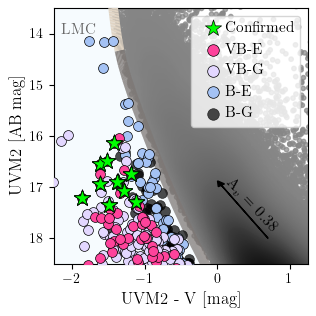

In [3]:
# Single CMD
f, ax = plt.subplots(1,1,figsize=(3.3,3.3))

colorspace = 'uvm2_v'
uv = 'uvm2'
opt = 'v'
galaxy = lmc
galaxy_label = "LMC"
counter_bottom =0

# Plot ZAMS
lc,zams_x,zams_y = galaxy.zams_threshold_plot(ax, uv, opt)
lc.set_linewidth(7)
ax.fill_betweenx(zams_y,np.repeat(-3,len(zams_y)),zams_x,alpha=background_a ,color=background_c,zorder=0)

# Formatting
xlabels  = ['UVM2 - V [mag]','UVW1 - B [mag]','U - V [mag]']
ylabels  = ['UVM2 [AB mag]','UVW1 [AB mag]','U [AB mag]']
ax.set_xlabel(xlabels[0],fontsize=labelsize)
ax.set_ylabel(ylabels[0],fontsize=labelsize)
ax.tick_params(axis='both', labelsize=ticksize)
ax.set_ylim(18.5,13.5)
ax.set_xlim(-2.25,1.25)

# Plot kdes
k_df = galaxy.kdes[colorspace]
x,y,z = k_df[f'{colorspace}_x'],k_df[f'{colorspace}_y'],k_df[f'{colorspace}_z']
if galaxy_label == "LMC":
    ax.scatter(x - 0.05,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=0.7)
else:
    ax.scatter(x,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=0.7)

# Plot Stars by rank 
for rank,rank_color,alpha,z in zip(ranks,rank_colors,alphas,zorders):
    edge_color='k'
    uv, opt = colorspace.split('_')
    df = galaxy.candidates
    rf = df[(df[f'{uv} - {opt}'] == 'blue') & (df['cut'] == rank)]
    x = rf[f'{uv}'] - rf[f'{opt}']
    y = rf[f'{uv}']
    ax.scatter(x,y,s=50,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,marker="o",alpha=alpha,zorder=z)
    # For legend
    ax.scatter(0,0,s=70,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,zorder=10,label=rank,marker="o",alpha=alpha)

    # Plot confirmed candidates 
    obs_stars = [f'Star_{i}' for i in range(1,17)]
    confirmed = df[df['discovery_name'].isin(obs_stars)]
    x = confirmed[f'{uv}'] - confirmed[f'{opt}']
    y = confirmed[f'{uv}']
    ax.scatter(x,y,s=150,edgecolor='k',facecolor='lime',linewidth=0.5,marker="*",alpha=1,zorder=100,label='Confirmed')

# Av Arrow
offsets_r = [11, 11]
offsets_x = [-15, -15]
offsets_y = [-15, -15]
galaxy.plot_arrow(ax,x=0.7,y=18,
                blue_band=uv,red_band=opt,
                offset_x = offsets_x[counter_bottom], offset_y = offsets_y[counter_bottom], offset_r = offsets_r[counter_bottom], 
                fontsize=textsize)
ax.text(-2.15,14,galaxy_label,fontsize = textsize,weight='bold',color='dimgray')
    
# Legend
handles, labels = ax.get_legend_handles_labels()
# Only plot Drout+23 once
handles = [[handles[1]] + [handles[0]] + [handles[2]] + [handles[4]] + [handles[6]]]
labels = [[labels[1]] + [labels[0]] + [labels[2]] + [labels[4] ]+ [labels[6]]]
# Combine handles
ax.legend(handles[0],labels[0],fontsize=legendsize,loc='upper right',handletextpad=-0.2)

    
plt.tight_layout()
#plt.savefig(f'CMD_Single_Single.pdf',dpi=300,bbox_inches='tight');

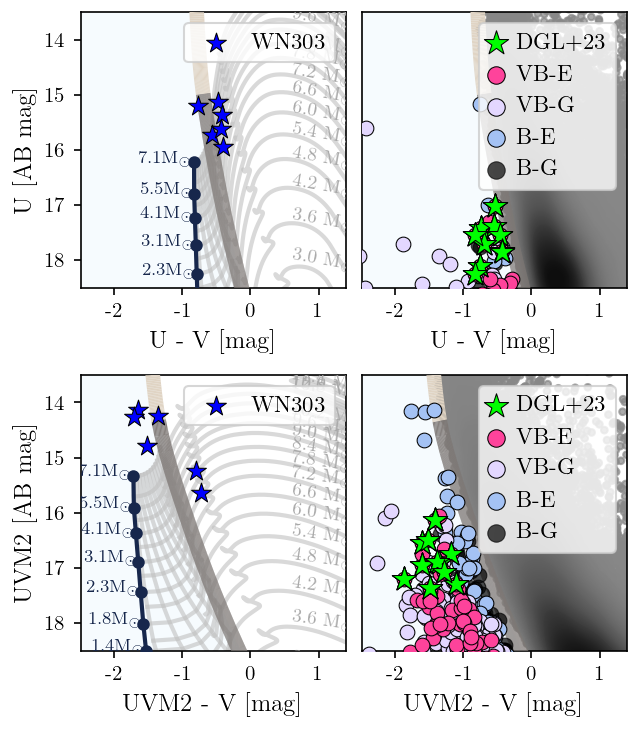

In [122]:
f, axes = plt.subplots(2,2,figsize=(4.4,5.),dpi=150)


galaxy = lmc

# Plot ZAMS
counter = 0
for ax, colorspace in zip([axes[0,0],axes[0,1],axes[1,0],axes[1,1]], ['u_v','u_v','uvm2_v','uvm2_v']):
    uv, opt = colorspace.split('_')
    lc,zams_x,zams_y = galaxy.zams_threshold_plot(ax, uv, opt)
    lc.set_linewidth(7)
    ax.fill_betweenx(zams_y,np.repeat(-3,len(zams_y)),zams_x,alpha=background_a ,color=background_c,zorder=0)

    # Zams Box
    Ox = [-0.4,-0.4,-0.5,-0.5]
    Or = [-84,-84,-80,-80]
    Bx = [-0.15,0.15,0.05]
    Br = [-69,-70,-76]
    #galaxy.ostar_box(ax,x=Ox[counter] ,rotation=Or[counter],fontsize=textsize-3)
    #galaxy.bstar_box(ax,x=Bx[counter],rotation=Br[counter],fontsize=textsize-3)

    # Formatting
    ax.set_xlabel(f'{uv.upper()} - {opt.upper()} [mag]',fontsize=labelsize)
    ax.set_ylabel(f'{uv.upper()} [AB mag]',fontsize=labelsize)
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.set_ylim(18.5,13.5)
    ax.set_xlim(-2.49,1.4)
    ax.set_xticks([-2,-1,0,1])
    ax.set_xticklabels([-2,-1,0,1])

    counter += 1

# THEORY
counter = 0
for ax, colorspace, mesa_df in zip([axes[0,0],axes[1,0]], ['u_v','uvm2_v'], [mesa_df['Z$_{LMC}$'], mesa_df['Z$_{SMC}$']]):
    uv, opt = colorspace.split('_')

    # Evolutionary Models - Stripped stars
    evol = galaxy.composites[galaxy.composites.frac_MS==0.0]
    evol = evol.iloc[np.arange(0,evol.shape[0]+1,2)]
    evol_x = evol[uv] - evol[opt]
    evol_y = evol[uv]
    ax.plot(evol_x,evol_y,'-o',linewidth=2.,markersize=5,color='#17274C',zorder=10)
    M = evol.M_strip.unique()
    m_start = [1.5,1.5]
    for m,ex,ey in zip(M,evol_x, evol_y):   
       # if m > m_start[counter]:
        ev_txt_x = ex - 0.8
        ev_txt_y = ey
        if np.round(m,1) == 6.3:
            ax.text(ev_txt_x,ev_txt_y-0.05,f'{np.round(m,1)}M'+r'$_\odot$',fontsize=textsize-2.5,color='#17274C',rotation=0,clip_on=True)
            #  ax.text(ev_txt_x+0.52,ev_txt_y+0.11-0.05,r'$\odot$',fontsize=textsize-1,color='#17274C',rotation=0)
        else:
            ax.text(ev_txt_x,ev_txt_y,f'{np.round(m,1)}M'+r'$_\odot$',fontsize=textsize-2.5,color='#17274C',rotation=0,clip_on=True)
            #  ax.text(ev_txt_x+0.52,ev_txt_y+0.11,r'$\odot$',fontsize=textsize-1,color='#17274C',rotation=0,clip_on=True)


    # Composite Models
    composites = galaxy.composites[galaxy.composites.frac_MS==0.2]

    web_m = [np.round(i,1) for i in np.arange(1.2,9.0,0.6)]
    composites_web = composites[composites.M_MS.isin(web_m)].copy().reset_index(drop=True)
    distances = galaxy.DistanceFromZamsForModels(composites_web,uv,opt)
    composites_web = composites_web[distances < 0]
    
    # Vertical lines
    #[2.21, 2.44, 2.7 , 2.99, 3.3 , 3.65, 4.04, 4.46, 4.93, 5.45, 6.03, 6.66, 7.37]
    for M in composites_web.M_MS.unique():
        comp_row = composites_web[composites_web.M_MS == M]
        comp_x = comp_row[uv] - comp_row[opt]
        comp_y = comp_row[uv]
        ax.plot(comp_x, comp_y,'-',color='silver',linewidth=2,alpha=0.6,zorder=1)

    for M in composites_web.Minit_strip.unique():
        evol_row = evol[evol.Minit_strip == M]
        comp_row = composites_web[composites_web.Minit_strip == M]
        evol_x = evol_row[uv] - evol_row[opt]
        evol_y = evol_row[uv]
        comp_x = comp_row[uv] - comp_row[opt]
        comp_y = comp_row[uv]
        model_x = np.append(evol_x,comp_x)
        model_y = np.append(evol_y,comp_y)
        ax.plot(model_x, model_y,'-',color='silver',linewidth=2,alpha=0.6)

    # Evolutionary Models - MS 
    vals = [float(f[:3]  + '.' + f[3]) for f in galaxy.mist_fnames]
    rotation = [-10,-8,-25]
    text_offset = [0.15,0.15]
    for mdf,val in zip(mesa_df,vals):
        m_x = mdf[uv.upper()] - mdf[opt.upper()]
        m_y = mdf[uv.upper()]
        ax.plot(m_x,m_y,color='silver',linewidth=2,alpha=0.6,zorder=0)
        # What is y when uv - opt = 1
        diff = np.abs(m_x - 1)
        mlabel_y = m_y[diff.argmin()]
        ax.text(.6,mlabel_y-0.05,f'{val} M'+r'$_\odot$',fontsize=textsize-2,color='darkgrey',rotation=rotation[counter],clip_on=True) 

    # Subdwarfs 
    # x, y, dx, dy 
    if counter == 0:
        sd_x = -2.46
        sd_y = 17.76
        sd_color = 'midnightblue'
      #  ax.text(sd_x+0.15,sd_y,'Sub',fontsize=textsize-1.5,color=sd_color,va='center')
       # ax.text(sd_x,sd_y+0.25,'dwarfs',fontsize=textsize-1.5,color=sd_color,va='center')
       # ax.arrow(sd_x+0.4,sd_y+0.35,0,0.25,head_width=0.1, head_length=0.06, fc=sd_color, ec=sd_color,zorder=10)
    
    # Wolf Rayet Stars 
    wr_color = 'darkred'

    wn = lmc.wr[lmc.wr.type=='wn303']
    wn_x = wn[uv.upper()] - wn[opt.upper()]
    wn_y = wn[uv.upper()]
    ax.scatter(wn_x,wn_y,s=100,edgecolor='black',facecolor='blue',linewidth=0.5,zorder=10,marker="*",label='WN303')
    wr = lmc.wr[lmc.wr.type=='wr']
    wr_x = wr[uv.upper()] - wr[opt.upper()]
    wr_y = wr[uv.upper()]
    # Plot WR 
    if counter_top == 2:
        ax.scatter(wr_x,wr_y,s=100,edgecolor='black',facecolor=wr_color,linewidth=0.5,zorder=10,marker="*",label='WR',clip_on=True)
    # Plot arrow pointing up
    # x, y, dx, dy 
    wr_x = -1.8
    wr_y = 14.7 
    #ax.arrow(wr_x-0.2,wr_y-0.2,0,-0.25,head_width=0.1, head_length=0.1, fc=wr_color, ec=wr_color,zorder=10)
    #ax.annotate(f'WR', xy=(wr_x+0.3, 0.5/2 + wr_y), xytext=(-28, 7), textcoords='offset points',color=wr_color,fontsize=textsize,
              #  family="serif",font="Times New Roman",weight="bold",va='center')
    ax.legend(loc='upper right',fontsize=legendsize,handletextpad=0.5)

    counter += 1

# OBSERVED
counter = 0
for ax, colorspace in zip([axes[0,1],axes[1,1]], ['u_v','uvm2_v']):
    uv, opt = colorspace.split('_')

    # Plot Stars by rank 
    for rank,rank_color,alpha,z in zip(ranks,rank_colors,alphas,zorders):
        df = galaxy.candidates
        # Plot confirmed candidates 
        obs_stars = [f'Star_{i}' for i in range(1,17)]
        confirmed = df[df['discovery_name'].isin(obs_stars)]
        x = confirmed[f'{uv}'] - confirmed[f'{opt}']
        y = confirmed[f'{uv}']

        ax.scatter(x,y,s=150,edgecolor='k',facecolor='lime',linewidth=0.5,marker="*",alpha=1,zorder=100,label='DGL+23',clip_on=True)

        edge_color='k'
        uv, opt = colorspace.split('_')
        df = galaxy.candidates
        rf = df[(df[f'{uv} - {opt}'] == 'blue') & (df['cut'] == rank)]
        x = rf[f'{uv}'] - rf[f'{opt}']
        y = rf[f'{uv}']
        ax.scatter(x,y,s=50,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,marker="o",alpha=alpha,zorder=z,clip_on=True)
        # For legend
        ax.scatter(0,0,s=70,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,zorder=10,label=rank,marker="o",alpha=alpha,clip_on=True)

    # Plot kdes
    k_df = galaxy.kdes[colorspace]
    x,y,z = k_df[f'{colorspace}_x'],k_df[f'{colorspace}_y'],k_df[f'{colorspace}_z']
    if counter == 0:
        ax.scatter(x - 0.05,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=0.7,clip_on=True)
    else:
        ax.scatter(x,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=0.7,clip_on=True)
    
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    # Only plot Drout+23 once
    desired_labels = ['DGL+23','VB-E', 'VB-G', 'B-E', 'B-G']
    handles = [handles[labels.index(dl)] for dl in desired_labels if dl in labels]
    # Combine handles
    ax.legend(handles,desired_labels,fontsize=legendsize,loc='upper right',handlelength=0.6,handletextpad=0.6)#,handletextpad=-0.2)
    counter_bottom += 1
    
    
    counter += 1

#         # Av Arrow 
#         offsets_r = [6, 4, 4, 5, 5, 5]
#         offsets_x = [-15, -10, -12, -17, -16, -14]
#         offsets_y = [-13, -18, -11, -12, -11, -13]
#         galaxy.plot_arrow(ax,x=0.7,y=18,
#                         blue_band=uv,red_band=opt,
#                         offset_x = offsets_x[counter_bottom], offset_y = offsets_y[counter_bottom], offset_r = offsets_r[counter_bottom], 
#                         fontsize=textsize)
#         ax.text(-2.35,14,galaxy_label,fontsize = legendsize+2,weight='bold',color='dimgray')


#Turn off ylabels if not in first column
for i in range(2):
    for ax in axes[i,1:]:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_yticks([])

        
plt.tight_layout(w_pad=0.75,h_pad=1)
# plt.savefig(f'CMD.png',dpi=1000,bbox_inches='tight');